<a href="https://colab.research.google.com/github/senasung37/AI07/blob/main/Section4_project_AI07_%EC%84%B1%EC%84%B8%EC%9D%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN - 이미지 분류

##데이터 수집 및 전처리

###세팅

In [ ]:
#라이브러리 설치
!pip install tensorflow_addons
!pip install bing-image-downloader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split

import glob
import imageio
import os
import PIL
import PIL.Image
import time


import shutil
from bing_image_downloader import downloader

     |████████████████████████████████| 1.1 MB 8.6 MB/s 


###데이터 수집 - 이미지 크로울링

In [ ]:
#이미지 크롤링 라이브러리
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 86 (delta 38), reused 46 (delta 16), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [ ]:
#구글마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#이전 세션폴더 삭제
!rm -rf interior

In [ ]:
#초기 디렉토리
directory_list = [
                  './interior/train/',
                  './interior/test/'
                  ]

for directory in directory_list:
  if not os.path.isdir(directory):
    os.makedirs(directory)

In [ ]:
#수집한 이미지 train/test로 구분하는 함수
def dataset_split(query, train_cnt):
 #train/test 디렉토리 만들기
  for directory in directory_list:
    if not os.path.isdir(directory+'/'+query):
      os.makedirs(directory+'/'+query)
  #데이터셋 준비
  cnt = 0
  for file_name in os.listdir(query):
    if cnt < train_cnt:
      print(f'[train dataset] {file_name}')
      shutil.move(query + '/' + file_name, './interior/train/' + query + '/' + file_name)
    else:
      print(f'[test dataset] {file_name}')
      shutil.move(query + '/' + file_name, './interior/test/' + query + '/' + file_name)
    cnt += 1
  shutil.rmtree(query)


In [ ]:
#이미지 다운로드
queries = ['home Industiral interior', 'home Bohemian interior', 'home Scandinavian interior', 'home antique Interior', 'home korean traditional interior']
for query in queries:
  downloader.download(query, limit=100, output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
  dataset_split(query, 80)

[%] Downloading Images to /content/home Industiral interior


[!!]Indexing page: 1

[%] Indexed 100 Images on Page 1.


[%] Downloading Image #1 from https://i.pinimg.com/originals/5b/75/04/5b7504cc3adbd4df7590f437f83a9125.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://interior-design.cy/wp-content/uploads/2020/02/Modern-Industrial-Interior-Design-Definition-Home-Decor.jpg
[!] Issue getting: https://interior-design.cy/wp-content/uploads/2020/02/Modern-Industrial-Interior-Design-Definition-Home-Decor.jpg
[!] Error:: <urlopen error [Errno -2] Name or service not known>
[%] Downloading Image #2 from https://i.pinimg.com/originals/3a/18/0d/3a180d62a05a081ee75c454ae4a85435.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://cdn.decoist.com/wp-content/uploads/2014/01/Metal-staircase-in-an-industrial-home.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://www.impressiveinteriordesign.com/wp-content/uploads/2015/05/Modern-Industrial-Interior-Design-De

In [ ]:
#구글드라이브로 폴더 복사
!cp interior -r "/content/drive/MyDrive/"

###데이터 전처리

In [ ]:
#이미지 경로
path_train = '/content/drive/MyDrive/interior/train'
path_test = '/content/drive/MyDrive/interior/test'

In [ ]:
#이미지 데이터셋으로 불러오기
train = tf.keras.preprocessing.image_dataset_from_directory(path_train, labels='inferred', label_mode='int', image_size=(180, 180))
test = tf.keras.preprocessing.image_dataset_from_directory(path_test, labels='inferred', label_mode='int', image_size=(180, 180))

Found 399 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


In [ ]:
#성능 높이기
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

##모델 학습 및 테스트

###모델 구축

In [ ]:
#시드 고정
tf.random.set_seed(12)
#모델 구축
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(254, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['Accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
#이미지 에러의 경우
from pathlib import Path
import imghdr

data_dir = [path_train, path_test]
image_extensions = [".png", ".jpg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for dir in data_dir:
  for filepath in Path(dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/drive/MyDrive/interior/train/home Scandinavian interior/Image_10.jpg is a webp, not accepted by TensorFlow


###모델 학습

In [ ]:
model.fit(train,
          batch_size=64,
          validation_data=(test),
          epochs=10)

Epoch 1/10
13/13 [==============================] - 19s 184ms/step - loss: 1.6203 - Accuracy: 0.2381 - val_loss: 1.6039 - val_Accuracy: 0.2100
Epoch 2/10
13/13 [==============================] - 0s 17ms/step - loss: 1.5230 - Accuracy: 0.3509 - val_loss: 1.6727 - val_Accuracy: 0.3300
Epoch 3/10
13/13 [==============================] - 0s 16ms/step - loss: 1.4955 - Accuracy: 0.3634 - val_loss: 1.4568 - val_Accuracy: 0.3600
Epoch 4/10
13/13 [==============================] - 0s 16ms/step - loss: 1.3784 - Accuracy: 0.4236 - val_loss: 1.3899 - val_Accuracy: 0.3800
Epoch 5/10
13/13 [==============================] - 0s 17ms/step - loss: 1.4150 - Accuracy: 0.3509 - val_loss: 1.4939 - val_Accuracy: 0.3400
Epoch 6/10
13/13 [==============================] - 0s 17ms/step - loss: 1.4192 - Accuracy: 0.4035 - val_loss: 1.3863 - val_Accuracy: 0.4000
Epoch 7/10
13/13 [==============================] - 0s 16ms/step - loss: 1.2418 - Accuracy: 0.4787 - val_loss: 1.3543 - val_Accuracy: 0.4500
Epoch 8/10


**결과 정리**<br>
- cache, 정규화 진행<br>
 25s 2s/step - loss: 0.0482 - accuracy: 0.9925 - val_loss: 3.5091 - val_accuracy: 0.3200
:
- cache만 진행<br>
 model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))) 삭제 <br>
24s 2s/step - loss: 0.0771 - accuracy: 0.9825 - val_loss: 5.2148 - val_accuracy: 0.3500 <br>

- cache, 정규화 모두 진행 x <br>
32s 2s/step - loss: 0.0567 - accuracy: 0.9850 - val_loss: 6.8763 - val_accuracy: 0.2800

- 모델 층 변경(cache 및 정규화 x) <br>
21s 1s/step - loss: 0.0223 - accuracy: 0.9975 - val_loss: 4.6422 - val_accuracy: 0.4100
 <br> 
- 모델 층 변경 후 cache 추가 <br>
14s 1s/step - loss: 0.0140 - accuracy: 0.9950 - val_loss: 3.2272 - val_accuracy: 0.3400
<br> 
- 모델 층 변경 후 정규화 추가<br>
21s 1s/step - loss: 0.1622 - accuracy: 0.9850 - val_loss: 1.9845 - val_accuracy: 0.3800
<br><br>
- [최종] 모델 층 변경 후 cache 및 정규화 추가 <br>
loss: 0.0452 - accuracy: 0.9950 - val_loss: 2.5791 - val_accuracy: 0.4300
<br>
- 시드 고정 후 dropout(0.5) 추가 <br>
loss: 1.6080 - Accuracy: 0.1980 - val_loss: 1.6091 - val_Accuracy: 0.2233
<br>
- 층 2개 추가, dropout(0.2) 추가 <br>
loss: 1.4327 - Accuracy: 0.3434 - val_loss: 1.5136 - val_Accuracy: 0.2816
<br>
- 클래스 3개로 축소, sample 수 1000으로 늘림 <br>
94s 1s/step - loss: 0.0066 - Accuracy: 0.9971 - val_loss: 0.0523 - val_Accuracy: 0.9899
<br>
- model.evaluate 결과<br>
loss: 0.0523 - Accuracy: 0.9899 - 6s/epoch - 336ms/step
[0.052330490201711655, 0.9899328947067261]<br>

- 클래스 5개로 늘림, sample 수 1000 <br>
loss: 0.0284 - Accuracy: 0.9942 - val_loss: 0.1846 - val_Accuracy: 0.9398 <br>
 <br>
- Mid-century modern or modern 추가하면 성능 급 떨어짐<br>
- 샘플 수 다시 100개로 했을 때 결과<br>
17ms/step - loss: 1.0094 - Accuracy: 0.5965 - val_loss: 1.3613 - val_Accuracy: 0.450


In [ ]:
model.evaluate(test, verbose=2)

4/4 - 0s - loss: 1.3613 - Accuracy: 0.4500 - 37ms/epoch - 9ms/step


[1.3613018989562988, 0.44999998807907104]

#DCGAN - 이미지 생성

###데이터 전처리

In [ ]:
#구글마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#이미지 경로
path_data = '/content/drive/MyDrive/interior2'

In [ ]:
#이미지 데이터셋으로 불러오기
dataset = tf.keras.preprocessing.image_dataset_from_directory(path_data, label_mode=None, image_size=(128, 128), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 994 files belonging to 1 classes.


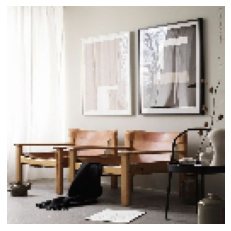

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

###모델 구축

In [ ]:
#discriminaotr 모델 구축
disc = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
     
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.1),
     
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.1),
     
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.1),
       
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
disc.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)     

In [ ]:
#generator 모델 구축
latent_dim = 128

gen = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8*8*128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
     
    ],
    name="generator",
)
gen.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [ ]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images *= 255
          generated_images.numpy()
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              img.save("gan/generated_img_%03d_%d.png" % (epoch, i))
              !cp gan -r "/content/drive/MyDrive/"
          

###모델 학습

In [ ]:
#이전에 생성된 이미지 지우기
!rm -rf gan
#이미지 저장할 폴더 생성
!mkdir gan

In [ ]:
epochs = 1000  # In practice, use ~100 epochs

gan = GAN(discriminator=disc, generator=gen, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/1000
32/32 [==============================] - 54s 1s/step - d_loss: 0.5937 - g_loss: 0.8019
Epoch 2/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.3588 - g_loss: 1.6425
Epoch 3/1000
32/32 [==============================] - 46s 1s/step - d_loss: 1.0023 - g_loss: 1.1775
Epoch 4/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.2096 - g_loss: 3.4290
Epoch 5/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.0576 - g_loss: 10.5281
Epoch 6/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.3453 - g_loss: 61.2650
Epoch 7/1000
32/32 [==============================] - 46s 1s/step - d_loss: 1.6345 - g_loss: 2.2870
Epoch 8/1000
32/32 [==============================] - 46s 1s/step - d_loss: -0.0555 - g_loss: 14.1429
Epoch 9/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.3397 - g_loss: 13.5469
Epoch 10/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.3002 - g_loss: 1

In [ ]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.5521 - g_loss: 1.5336
Epoch 2/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.6491 - g_loss: 1.7803
Epoch 3/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.5509 - g_loss: 1.6718
Epoch 4/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.5476 - g_loss: 1.4909
Epoch 5/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.4013 - g_loss: 1.7666
Epoch 6/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.4722 - g_loss: 1.6053
Epoch 7/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.7397 - g_loss: 1.3699
Epoch 8/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.5686 - g_loss: 1.4756
Epoch 9/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.5906 - g_loss: 1.4467
Epoch 10/1000
32/32 [==============================] - 46s 1s/step - d_loss: 0.4815 - g_loss: 1.4382